In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import time
from numba import jit

# Rao-Blackwellization of the independent Metropolis-Hasting algorithm

Use this cell to define the function target, the distribution target, using scipy otherwise it won't work. 
Since we want to estimate $\mathbb{E}[h(x)]$, we also need to define both h and the true mean. The functions h will be used in the comparative analysis part of this notebook

In [4]:
f = stats.t(df=3)  # Target distribution
g = stats.cauchy()  # Proposal distribution

#To compute the mean of f 
@jit(nopython=True)
def h1(x):
    return x
true_mean1 = 0 #mean of f

#To compute tail probability of f
y = f.ppf(0.95) #f.ppf(0.95) gives us y so that P(X>y)=0.05 where X has f for density
@jit(nopython=True)
def h2(x):
    return np.where(x>y,1,0) 
true_mean2 = 0.05 

## The independent Metropolis-Hasting algorithm

Time to compute : 2.5791218280792236
Acceptance Rate : 81.49%


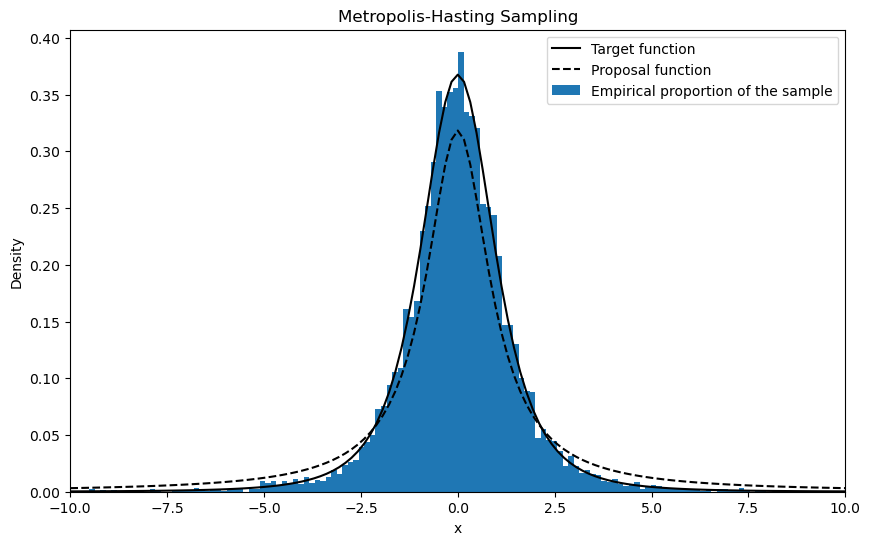

In [6]:
n = 10000

start_time = time.time()
samples = []
current_sample = f.rvs()  
compteur = 0

for _ in range(n):
    proposed_sample = g.rvs() 
    acceptance_ratio = min((f.pdf(proposed_sample) * g.pdf(current_sample)) / (f.pdf(current_sample) * g.pdf(proposed_sample)),1)

    if np.random.rand() < acceptance_ratio:
            current_sample = proposed_sample  
            compteur+=1
    samples.append(current_sample)  


end_time = time.time()
loop_time = (end_time - start_time) 
print(f"Time to compute : {loop_time}")
print(f"Acceptance Rate : {100*compteur/n:.2f}%")
xx = np.linspace(-10,10,125)
plt.figure(figsize=(10, 6))
plt.plot(xx,f.pdf(xx),color='black',label='Target function')
plt.plot(xx,g.pdf(xx),linestyle='--',color='black',label='Proposal function')
plt.hist(np.array(samples),density=True,bins='auto',label='Empirical proportion of the sample')
plt.xlim(-10,10)
plt.legend()
plt.title("Metropolis-Hasting Sampling")
plt.xlabel("x")
plt.ylabel("Density")
plt.show()

#### Optimized version of the Metropolis-Hasting Algorithm 
The @jit(nopython=True) line from Numba compiles the Python function into fast machine code that bypasses the Python interpreter entirely and makes it much faster. However, it does not work with scipy.stats function, so we need to split the function into two parts. However, it is very much worth it since using it make the metropolis-hasting algorithm several times faster. There is an additional parameter to choose wether or not the chain should start from the target distribution.

In [8]:
@jit(nopython=True)
def loop(num_samples,current_sample,proposed_samples,random_uniforms,F,G):
  
    accepted_samples = np.empty(num_samples + 1)  # Preallocate memory
    accepted_samples[0] = current_sample
     
    current_f_pdf = F[0]
    current_g_pdf = G[0]

    for i in range(1, num_samples + 1):
        proposed_f_pdf = F[i]
        proposed_g_pdf = G[i]
        
        # Calculate the acceptance ratio
        acceptance_ratio = min(1, (proposed_f_pdf / proposed_g_pdf) / 
                                 (current_f_pdf / current_g_pdf))
        
        # Decide whether to accept the proposal
        if random_uniforms[i] < acceptance_ratio:
            current_sample = proposed_samples[i]
            current_f_pdf = proposed_f_pdf  
            current_g_pdf = proposed_g_pdf
        
        accepted_samples[i] = current_sample
    return accepted_samples, proposed_samples

def metropolis_hastings(num_samples,target_density_start=True):
    current_sample = f.rvs() if target_density_start else g.rvs()
    proposed_samples = g.rvs(size=num_samples + 1)
    proposed_samples[0] = current_sample
    random_uniforms = np.random.rand(num_samples + 1)
    F = f.pdf(proposed_samples)
    G = g.pdf(proposed_samples)
    return loop(num_samples,current_sample,proposed_samples,random_uniforms,F,G)

start_time = time.time()
_,_ = metropolis_hastings(n)
end_time = time.time()
loop_time = (end_time - start_time) 
print(f"Time to compute : {loop_time}")

Time to compute : 0.3265955448150635


### Implementation of the Rao-Blackwellized and Importance-Sampling estimators :

In [10]:
def compute_pdf_values(Y, f, g):
    f_pdf_values = f.pdf(Y)
    g_pdf_values = g.pdf(Y)
    return f_pdf_values, g_pdf_values

@jit(nopython=True)
def compute_rho(f_pdf_values, g_pdf_values):
    w_values = f_pdf_values / g_pdf_values
    rho = np.minimum(1, w_values / w_values[:, np.newaxis])
    return rho

@jit(nopython=True)
def compute_zeta(Y, rho):
    n = len(Y)
    zeta = np.eye(n)  # Start with an identity matrix
    for i in range(n):
        zeta[i, i+1:] = np.cumprod(1 - rho[i, i+1:])
    return zeta

@jit(nopython=True)
def compute_deltas(zeta, rho, n):
    deltas = np.zeros(n + 1)
    deltas[0] = 1  # By convention, delta_0 = 1
    for i in range(1, n + 1):
        sum_term = 0
        for j in range(i):
            sum_term += deltas[j] * zeta[j, i - 1] * rho[j, i]
        deltas[i] = sum_term
    return deltas

@jit(nopython=True)
def compute_rb_estimator(Y, f_pdf_values, g_pdf_values,h):
    n = len(Y) - 1
    rho = compute_rho(f_pdf_values, g_pdf_values)
    zeta = compute_zeta(Y, rho)
    deltas = compute_deltas(zeta, rho, n)
    est = 0.0
    for i in range(n + 1):
        est += deltas[i] * np.sum(zeta[i, i:]) * h(Y[i]) / (n + 1)
    return est

@jit(nopython=True)
def compute_importance_sampling_estimator(Y, f_pdf_values, g_pdf_values,h):
    weights = f_pdf_values / g_pdf_values
    numerator = np.sum(weights * h(Y))
    denominator = np.sum(weights)
    return numerator / denominator

def compute_mc_estimator(Y,h):
    return np.mean(h(np.array(Y)))

In [11]:
#Parameters
number_of_samples = 1000
n = 250
h=h2
true_mean = true_mean2


#Generate Independent MH samples
accept_samples = []
proposed_samples = []
for _ in range(number_of_samples):
    accept, proposed = metropolis_hastings(n)
    accept_samples.append(accept)
    proposed_samples.append(proposed)


# Main calculation
res_RB = []
res_MC = []
res_IS = []  

for j in range(number_of_samples):
    accept = accept_samples[j]
    sample = proposed_samples[j]
    res_MC.append(compute_mc_estimator(accept,h))

    f_pdf,g_pdf = compute_pdf_values(sample, f, g)
    
    res_IS.append(compute_importance_sampling_estimator(sample,f_pdf,g_pdf,h))
    res_RB.append(compute_rb_estimator(sample,f_pdf,g_pdf,h))

    print(f"Progress: {100 * (j + 1) / number_of_samples:.2f}%", end='\r')

print("\n")

#Compute Statistics
print(f"Target mean: {true_mean}")
print(f"Classic MC empirical average mean: {np.mean(res_MC):.5f}")
print(f"Rao-Blackwell empirical average mean: {np.mean(res_RB):.5f}")
print(f"Importance Sampling empirical average mean: {np.mean(res_IS):.5f}")

classic_mc_mse = np.mean((np.array(res_MC) - true_mean) ** 2)
rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean) ** 2)
importance_sampling_mse = np.mean((np.array(res_IS) - true_mean) ** 2)

print(f"\nClassic MC MSE: {classic_mc_mse:.5f}")
print(f"Rao-Blackwell MSE: {rao_blackwell_mse:.5f}")
print(f"Importance Sampling MSE: {importance_sampling_mse:.5f}")

mse_decrease_rb = classic_mc_mse - rao_blackwell_mse
percent_decrease_rb = (mse_decrease_rb / classic_mc_mse) * 100

mse_decrease_is = classic_mc_mse - importance_sampling_mse
percent_decrease_is = (mse_decrease_is / classic_mc_mse) * 100

print("")
print(f"Percentage decrease in MSE (Rao-Blackwell vs Classic MC): {percent_decrease_rb:.2f}%")
print(f"Percentage decrease in MSE (Importance Sampling vs Classic MC): {percent_decrease_is:.2f}%")


Progress: 100.00%

Target mean: 0.05
Classic MC empirical average mean: 0.05030
Rao-Blackwell empirical average mean: 0.04984
Importance Sampling empirical average mean: 0.04993

Classic MC MSE: 0.00026
Rao-Blackwell MSE: 0.00013
Importance Sampling MSE: 0.00012

Percentage decrease in MSE (Rao-Blackwell vs Classic MC): 50.49%
Percentage decrease in MSE (Importance Sampling vs Classic MC): 54.80%


## Comparative Analysis of Estimation Techniques: Classic MC, Rao-Blackwell, and Importance Sampling :

In [13]:
# Parameters
sample_sizes = [5, 10, 25, 50, 100,200,500,1000]
number_of_samples = 20000 #reduce this to make this cell faster
target_density_start=[True,False]

# Matrices to store statistics for each M value
result_matrix_true_h1 = np.zeros((len(sample_sizes), 6))  
result_matrix_true_h2 = np.zeros((len(sample_sizes), 6))  
result_matrix_false_h1 = np.zeros((len(sample_sizes), 6))  
result_matrix_false_h2 = np.zeros((len(sample_sizes), 6)) 

compteur=0
for h,true_mean in zip([h1,h2],[true_mean1,true_mean2]):
    for start_density in target_density_start:
    
        if true_mean==true_mean1:
            result_matrix = result_matrix_true_h1 if start_density==True else result_matrix_false_h1
        else :
            result_matrix = result_matrix_true_h2 if start_density==True else result_matrix_false_h2
        
        for c, t in enumerate(sample_sizes):  # Loop over different sample sizes
            res_RB = []
            res_IS = []
            res_MC = []
            # Generate samples of size t
            samples_accept = []
            samples_proposal = []
            for _ in range(number_of_samples):
                accept, proposal = metropolis_hastings(t,start_density)
                samples_accept.append(accept)
                samples_proposal.append(proposal)
        
            # Compute estimators
            for j, sample in enumerate(samples_proposal):
                f_pdf,g_pdf = compute_pdf_values(sample, f, g)
                res_IS.append(compute_importance_sampling_estimator(sample,f_pdf,g_pdf,h))
                res_RB.append(compute_rb_estimator(sample,f_pdf,g_pdf,h))
                res_MC.append(compute_mc_estimator(samples_accept[j],h))
                # Progress display
                progress_message = f"{compteur+1}/{4} Sample size={t}, Progress: {100 * (j + 1) / number_of_samples:.2f}%"
                print(progress_message.ljust(60), end='\r')
        
            # Compute statistics
            result_matrix[c, 0] = np.mean(res_MC)  # Mean of classic MC results
            result_matrix[c, 1] = np.mean(res_RB)  # Mean of Rao-Blackwell results
            result_matrix[c, 2] = np.mean(res_IS)  # Mean of IS results
            
        
            classic_mc_mse = np.mean((np.array(res_MC) - true_mean)**2)
            rao_blackwell_mse = np.mean((np.array(res_RB) - true_mean)**2)
            importance_sampling_mse = np.mean((np.array(res_IS) - true_mean)**2)
        
            result_matrix[c, 3] = classic_mc_mse
            
            # Compute MSE reduction
            mse_decrease_rb = classic_mc_mse - rao_blackwell_mse
            percent_decrease_rb = (mse_decrease_rb / classic_mc_mse) * 100 if classic_mc_mse > 0 else 0
           
            mse_decrease_is = classic_mc_mse - importance_sampling_mse
            percent_decrease_is = (mse_decrease_is / classic_mc_mse) * 100 if classic_mc_mse > 0 else 0
            
            result_matrix[c, 4] = percent_decrease_rb
            result_matrix[c, 5] = percent_decrease_is
        compteur+=1


#### Estimation of the mean of the target distribution starting Metropolis-Hasting algorithm from the target density over 20000 runs :

In [15]:
results = [
    'MH estimate',
    'RB estimate',
    'IS estimate',
    'MC MSE',
    'Decrease in MSE RB over MH',
    'Decrease in MSE IS over MH']

df_results = pd.DataFrame(result_matrix_true_h1, index=sample_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MH estimate,RB estimate,IS estimate,MC MSE,Decrease in MSE RB over MH,Decrease in MSE IS over MH
Sample size,,,,,,
5,0.00788,0.00797,0.00618,0.58877,37.86156,49.22343
10,0.00176,-0.00393,-0.00414,0.33648,42.52388,51.89304
25,-0.00118,0.00068,0.00124,0.16835,53.99408,59.53288
50,-0.00051,-0.00003,-0.00048,0.07425,47.94348,53.82495
100,0.00313,0.00277,0.00293,0.03710,48.15562,53.70415
200,-0.00142,-0.00163,-0.00104,0.01849,47.71878,53.08578
500,0.00016,0.00001,-0.00001,0.00736,47.45584,52.60627
1000,-0.00049,-0.00017,-0.00009,0.00372,48.83020,53.57998


#### Estimation of the mean of the target distribution when starting the Metropolis-Hasting algorithm from the proposal density over 20000 runs:

In [17]:
df_results = pd.DataFrame(result_matrix_false_h1, index=sample_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MH estimate,RB estimate,IS estimate,MC MSE,Decrease in MSE RB over MH,Decrease in MSE IS over MH
Sample size,,,,,,
5,0.15563,0.15916,0.00063,2.838551e+03,0.01668,99.98829
10,0.07511,0.07160,-0.00197,7.970417e+01,0.20704,99.78855
25,75.16988,75.17264,-0.00139,1.129652e+08,0.00005,100.00000
50,0.00765,0.00664,0.00152,1.138520e+00,3.48642,96.94263
100,-0.00496,-0.00650,-0.00154,5.577900e-01,3.20528,96.96370
200,-0.03553,-0.03581,-0.00028,1.768443e+01,0.02659,99.95130
500,-0.01402,-0.01391,-0.00028,3.629910e+00,0.17215,99.90447
1000,-0.00009,0.00041,0.00017,5.390000e-03,34.20528,67.96336


#### Estimation of the tail probability 0.05 of the target distribution starting Metropolis-Hasting algorithm from the target density over 20000 runs :

In [19]:
df_results = pd.DataFrame(result_matrix_true_h2, index=sample_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MH estimate,RB estimate,IS estimate,MC MSE,Decrease in MSE RB over MH,Decrease in MSE IS over MH
Sample size,,,,,,
5,0.05072,0.05055,0.05047,0.01022,37.46733,45.40905
10,0.05047,0.05050,0.05052,0.00560,40.74779,47.92408
25,0.05025,0.05010,0.05005,0.00242,43.99563,49.76364
50,0.05022,0.05007,0.05012,0.00124,44.68305,50.41780
100,0.05021,0.05006,0.05007,0.00063,45.70704,51.33750
200,0.05025,0.05016,0.05013,0.00032,45.79664,51.69641
500,0.04997,0.04996,0.04995,0.00012,45.58954,50.93699
1000,0.05005,0.05000,0.05001,0.00006,46.30810,51.69195


#### Estimation of the tail probability 0.05 of the target distribution starting Metropolis-Hasting algorithm from the proposal density over 20000 runs :

In [21]:
df_results = pd.DataFrame(result_matrix_false_h2, index=sample_sizes, columns = results)
df_results.index.name = 'Sample size'

df_results.round(5)

,MH estimate,RB estimate,IS estimate,MC MSE,Decrease in MSE RB over MH,Decrease in MSE IS over MH
Sample size,,,,,,
5,0.06597,0.06654,0.05535,0.01320,25.71733,50.73173
10,0.05873,0.05866,0.05234,0.00664,35.04554,53.30029
25,0.05337,0.05339,0.05081,0.00254,40.34895,51.84985
50,0.05190,0.05195,0.05052,0.00130,43.39670,52.34650
100,0.05117,0.05114,0.05039,0.00066,45.05264,52.29912
200,0.05034,0.05047,0.05016,0.00032,44.16678,50.42028
500,0.05035,0.05030,0.05011,0.00013,45.26021,51.34369
1000,0.05020,0.05013,0.05009,0.00006,45.46986,51.08099


#### How many more sample do we have to generate using MH to achieve the same MSE as the Rao-Blackwell estimator with samples size = 200 ?

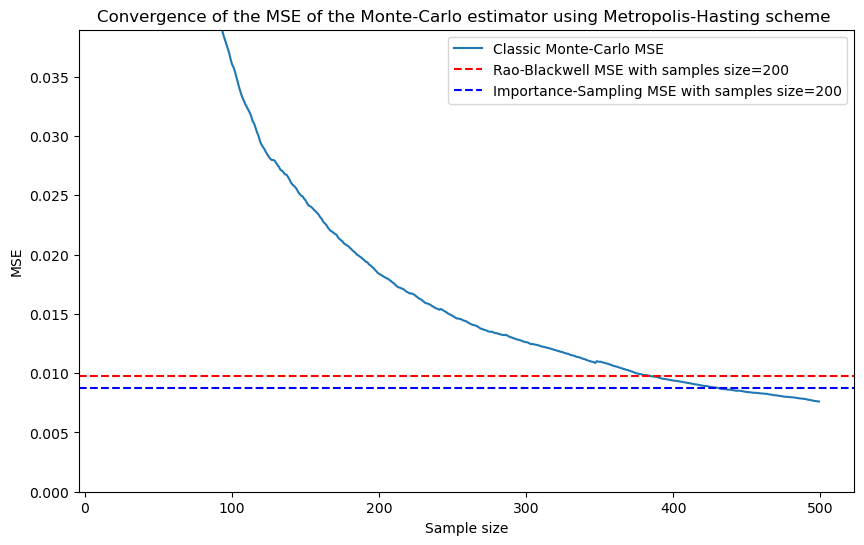

In [23]:
# Parameters :
tt = np.arange(20, 500, 1)
MSE_values = [0.018799-(0.018799 *0.482),0.018799-(0.018799*0.5354)]  
number_of_samples = 5000
h = h1
true_mean = true_mean1


mse_mh = np.zeros(len(tt))

for j in range(number_of_samples):
    accept, _ = metropolis_hastings(tt[-1])
    
    # For each t in tt, calculate MSE from the start of the chain up to t
    for i,t in enumerate(tt):
        subset_accept = accept[:t]
        MC_estimate = ((compute_mc_estimator(subset_accept,h)- true_mean) ** 2)/number_of_samples
        mse_mh[i]+= MC_estimate

    # Progress indicator
    progress = 100 * (j + 1) / number_of_samples
    print(f"Progress: {progress:.2f}%".ljust(50), end='\r')


plt.figure(figsize=(10, 6))
plt.plot(tt, mse_mh, label=f'Classic Monte-Carlo MSE')
plt.axhline(y=MSE_values[0], color='r', linestyle='--', label='Rao-Blackwell MSE with samples size=200')
plt.axhline(y=MSE_values[1], color='b', linestyle='--', label='Importance-Sampling MSE with samples size=200')
plt.legend()
plt.ylim(0, 4*MSE_values[0])
plt.xlabel('Sample size')
plt.ylabel('MSE')
plt.title("Convergence of the MSE of the Monte-Carlo estimator using Metropolis-Hasting scheme ")
plt.show()

#### Computation time comparison for the three estimators

In [25]:
# Parameters
size = 400
true_mean = 0  # True mean for MSE calculation
number_of_samples = 10000  # Number of runs for the average computation time and MSE
h=h1
true_mean=true_mean1

results = []

# Monte Carlo
start_time = time.time()
mse_classic_mc = 0

for i in range(number_of_samples):
    accept, _ = metropolis_hastings(size)
    temp = compute_mc_estimator(accept,h)
    mse_classic_mc += (temp - true_mean) ** 2  # Accumulate squared error
    print(f"Classic MC Progress: {100 * (i + 1) / number_of_samples:.2f}%", end='\r')

mse_classic_mc /= number_of_samples
end_time = time.time()
loop_time = (end_time - start_time) / number_of_samples

results.append({
    "Estimator": "Classic MC",
    "Size": size,
    "Time (s)": loop_time,
    "MSE": mse_classic_mc
})
print("")

# Rao-Blackwell
start_time = time.time()
samples_proposal = []
for _ in range(number_of_samples):
    accept, proposal = metropolis_hastings(200)
    samples_proposal.append(proposal)

res = []
for j, sample in enumerate(samples_proposal):
    f_pdf,g_pdf = compute_pdf_values(sample, f, g)
    res.append(compute_rb_estimator(sample,f_pdf,g_pdf,h))
    print(f"Rao-Blackwell Progress: {100 * (j + 1) / number_of_samples:.2f}%", end='\r')

mse_rao_blackwell = np.mean((np.array(res) - true_mean) ** 2)
end_time = time.time()
loop_time = (end_time - start_time) / number_of_samples

results.append({
    "Estimator": "Rao-Blackwell",
    "Size": 200,
    "Time (s)": loop_time,
    "MSE": mse_rao_blackwell
    })
print("")

# Importance Sampling
start_time = time.time()
samples_proposal = []
for _ in range(number_of_samples):
    accept, proposal = metropolis_hastings(200)
    samples_proposal.append(proposal)

res = []
for j, sample in enumerate(samples_proposal):
    f_pdf,g_pdf = compute_pdf_values(sample, f, g)
    res.append(compute_importance_sampling_estimator(sample,f_pdf,g_pdf,h))
    print(f"Importance Sampling Progress: {100 * (j + 1) / number_of_samples:.2f}%", end='\r')

mse_importance_sampling = np.mean((np.array(res) - true_mean) ** 2)
end_time = time.time()
loop_time = (end_time - start_time) / number_of_samples

results.append({
    "Estimator": "Importance Sampling",
    "Size": 200,
    "Time (s)": loop_time,
    "MSE": mse_importance_sampling
})
print("")
print(" ")
print("Results :")
results_df = pd.DataFrame(results).round(5)
print(results_df)

Classic MC Progress: 100.00%
Rao-Blackwell Progress: 100.00%
Importance Sampling Progress: 100.00%
 
Results :
             Estimator  Size  Time (s)      MSE
0           Classic MC   400   0.00022  0.00919
1        Rao-Blackwell   200   0.00043  0.00958
2  Importance Sampling   200   0.00035  0.00850
